In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib

In [2]:
# Data Files Locations

file_loc_train = "data_miccai/train"
file_loc_test = "data_miccai/test"
file_loc_val = "data_miccai/val"

In [3]:
# list of all the folders in the train location 
list_of_dir  = os.listdir(file_loc_train)

print("Total folders :", len(list_of_dir))

Total folders : 1000


In [4]:
def clean_data_realnumber(pd_data):
    row,column = pd_data.shape
    
    for i in range(row):
        for j in range(column):
            if pd_data.iloc[i,j] == 0:
                val1 = 0
                val2 = 0
                
                tmp = i
                
                while(True):
                    if tmp > 0 and pd_data.iloc[tmp,j]>0:
                        val1 = pd_data.iloc[tmp,j]
                        break
                    elif tmp<=0:
                        break
                    tmp-=1
                
                tmp = i
                while(True):
                    if tmp < row and pd_data.iloc[tmp,j]>0:
                        val1 = pd_data.iloc[tmp,j]
                        break
                    elif tmp>=row:
                        break
                    tmp+=1
                
                if val1>0 and val2>0:
                    pd_data.iloc[i,j] = (val1 + val2)/2
                else:
                    pd_data.iloc[i,j] = val1 + val2
    
    return pd_data

In [5]:
# This function will find the average of the values in a column.
# It will skip the cell with value zero "0".

def blood_data_avg(pd_data):
    
    pd_data = clean_data_realnumber(pd_data)
    
    row,column = pd_data.shape
    
    arr_val = [0]*column
    
    for i in range(column):
        sm = 0
        cnt = 0
        for j in range(row):
            if pd_data.iloc[j,i] != 0:
                sm += pd_data.iloc[j,i]
                cnt+=1
        arr_val[i] = sm/cnt
    return arr_val


def radiology_data_avg(pd_data):
    row,column = pd_data.shape
    
    arr_val = [0]*column
    
    for i in range(column):
        sm = 0
        cnt=0
        if i==0:
            for j in range(row):
                if pd_data.iloc[j,i] != 0:
                    sm += pd_data.iloc[j,i]
                    cnt+=1
            arr_val[i] = sm/(cnt*1.0)
        else:
            for j in range(row):
                if(pd_data.iloc[j,i] == True):
                    sm+=1
                cnt+=1
            if(sm>=(cnt/2.0)):
                arr_val[i]=1
    return arr_val

def temperature_data_avg(pd_data):
    
    pd_data = clean_data_realnumber(pd_data)
    
    row,column = pd_data.shape
    
    arr_val = [0]*column
    
    for i in range(column):
        sm = 0
        cnt = 0
        for j in range(row):
            if pd_data.iloc[j,i] != 0:
                sm += pd_data.iloc[j,i]
                cnt+=1
        arr_val[i] = sm/cnt
    return arr_val

def outcome_data_avg(pd_data):
    
    row,column = pd_data.shape
    
    output = 0
    for i in range(1,column):
        if pd_data.iloc[0,i] == 1:
            output += 2**(2-(i-1))
    return output
    

In [6]:
output_combined_file_loc = "output/data_blood_radiology_temperature_train.csv"
Y_file_loc = "output/Y_blood_radiology_temperature_train.csv"

output_combined = []
Y = []

for i in list_of_dir:
    cd_list_of_dir = file_loc_train+"/"+i
    
    file_read_blood = pd.read_csv(cd_list_of_dir+"/data_bloodvalues.csv", sep=",")
    file_read_radiology = pd.read_csv(cd_list_of_dir+"/data_radiology.csv", sep=",")
    file_read_temperature = pd.read_csv(cd_list_of_dir+"/data_temperature.csv", sep=",")
    
    file_read_outcome = pd.read_csv(cd_list_of_dir+"/outcome.csv", sep=",")
    Y.append(outcome_data_avg(file_read_outcome))
    
    output_combined.append(blood_data_avg(file_read_blood)[1:] + radiology_data_avg(file_read_radiology)[1:] + temperature_data_avg(file_read_temperature)[1:])

In [7]:
output_data_combined_pd = pd.DataFrame(output_combined)
output_data_combined_pd.to_csv(output_combined_file_loc, sep=',', index=False)

Y_pd = pd.DataFrame(Y)
Y_pd.to_csv(Y_file_loc, sep=',', index=False)

In [8]:
# Training XGBoost
X_train = output_data_combined_pd
y_train = Y_pd

In [9]:
# fit model no training data
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=50, max_depth=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [10]:
# list of all the folders in the train location 
list_of_dir  = os.listdir(file_loc_test)

print("Total folders :", len(list_of_dir))

Total folders : 250


In [11]:
output_combined_file_loc = "output/data_blood_radiology_temperature_test.csv"
Y_file_loc = "output/Y_blood_radiology_temperature_test.csv"

output_combined = []
Y = []

for i in list_of_dir:
    cd_list_of_dir = file_loc_test+"/"+i
    
    file_read_blood = pd.read_csv(cd_list_of_dir+"/data_bloodvalues.csv", sep=",")
    file_read_radiology = pd.read_csv(cd_list_of_dir+"/data_radiology.csv", sep=",")
    file_read_temperature = pd.read_csv(cd_list_of_dir+"/data_temperature.csv", sep=",")
    
    file_read_outcome = pd.read_csv(cd_list_of_dir+"/outcome.csv", sep=",")
    Y.append(outcome_data_avg(file_read_outcome))
    
    output_combined.append(blood_data_avg(file_read_blood)[1:] + radiology_data_avg(file_read_radiology)[1:] + temperature_data_avg(file_read_temperature)[1:])

In [12]:
output_data_combined_pd = pd.DataFrame(output_combined)
output_data_combined_pd.to_csv(output_combined_file_loc, sep=',', index=False)

Y_pd = pd.DataFrame(Y)
Y_pd.to_csv(Y_file_loc, sep=',', index=False)

In [13]:
# Training XGBoost
X_test = output_data_combined_pd
y_test = Y_pd

In [14]:
res = model.predict(X_test)

In [15]:
j = 0
cnt = 0
for i in y_test[0]:
    if i == res[j]:
        cnt+=1
    j+=1

print("accuracy:",cnt/len(res))

accuracy: 0.576


[[137, 6, 1, 1, 5, 0, 0, 0], [50, 4, 0, 0, 2, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0], [26, 1, 0, 0, 3, 0, 0, 0], [8, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0]]


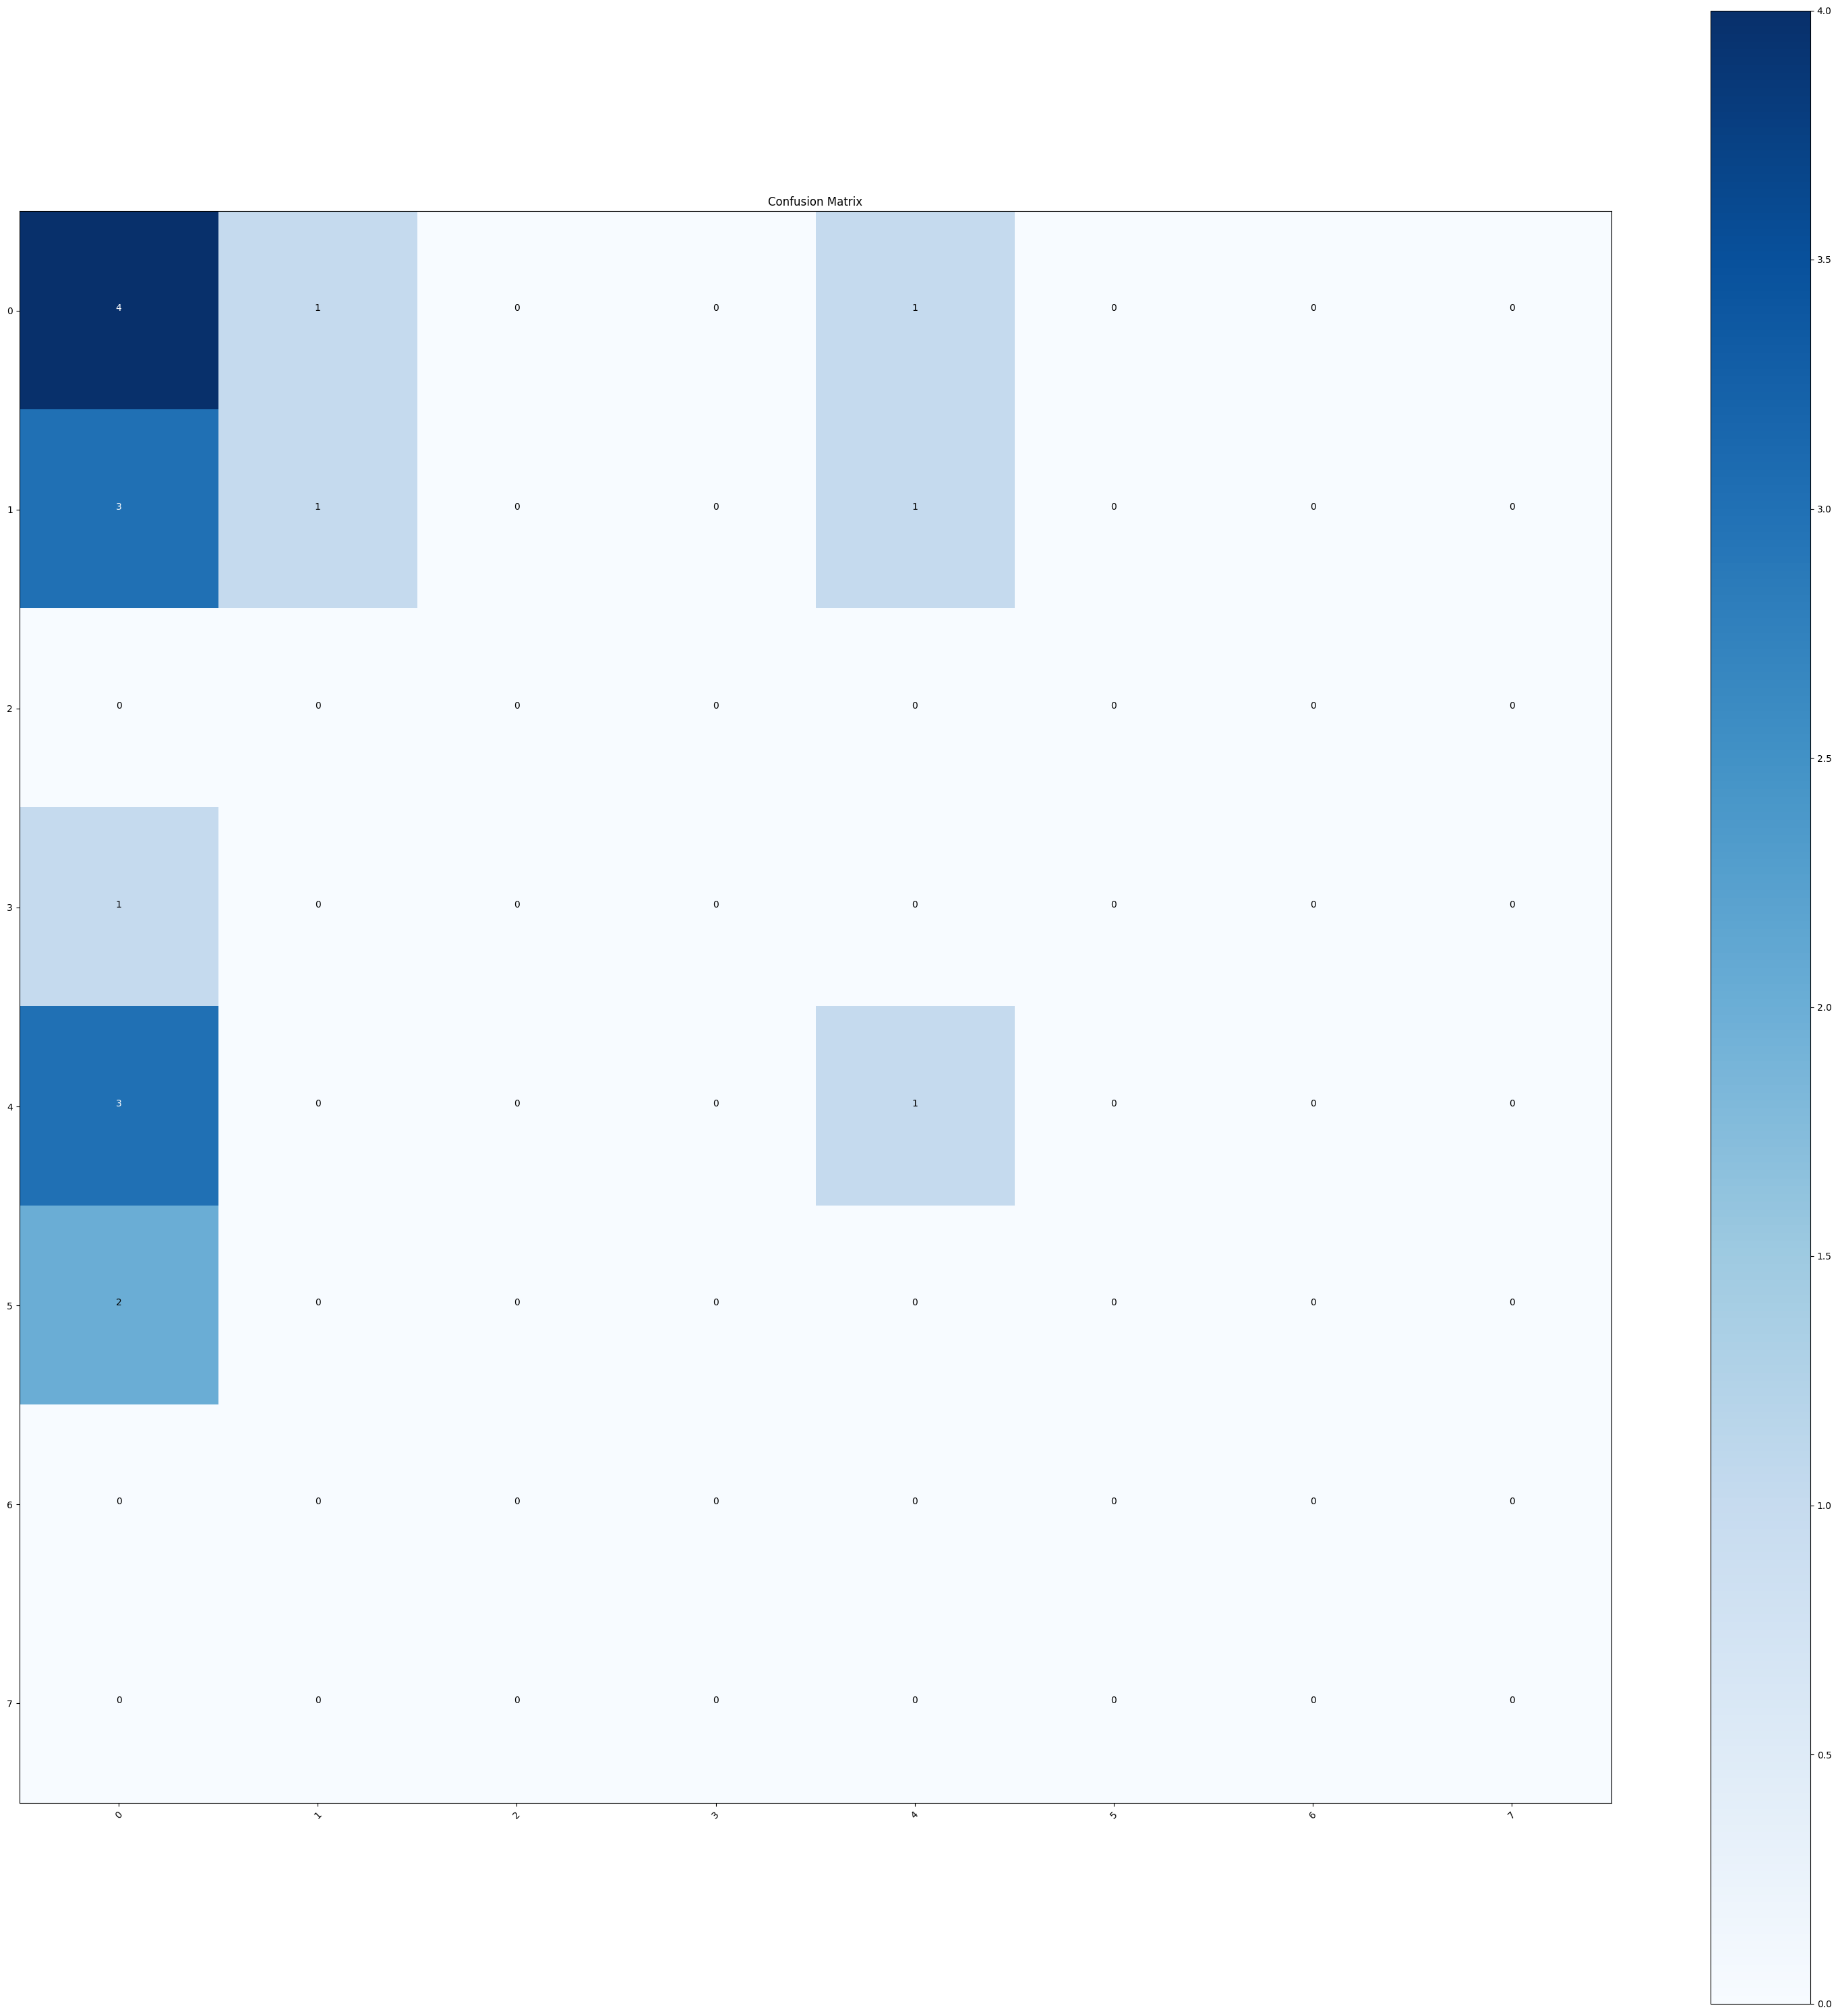

In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    cm = np.log(cm+1)
    cm = cm.astype("int32")

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(30,30))
    #plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.savefig("plot/XGBoost-WIMV.png")
    plt.show()


classes = list(range(8))

dic = {}
for i in range(len(classes)):
    dic[classes[i]] = i

cnf_array = []
for i in range(len(classes)):
    cnf_array.append([0]*len(classes))

for i in range(res.shape[0]):
    cnf_array[y_test[0][i]][res[i]]+=1

print(cnf_array)

plot_confusion_matrix(cm= np.array(cnf_array), 
                      normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")